<a href="https://colab.research.google.com/github/gheesung/object_detection_assignment/blob/master/Object_Detection_SSD_Mobinet_%26_Inception_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import cv2
import time
import argparse
import multiprocessing
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
!git clone --quiet https://github.com/gheesung/object_detection_assignment.git

In [0]:
!apt-get install -y -qq protobuf-compiler python-pil python-lxml


In [0]:
import os
os.chdir('/content/object_detection_assignment')

In [0]:
!protoc object_detection/protos/*.proto --python_out=.

In [0]:
import sys
sys.path.append('object_detection')

In [0]:

import object_detection.utils 
from object_detection.utils import label_map_util

In [0]:
# download the faster rcnn if want to test using this model (comment out if not required)
!rmdir object_detection/faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017
!curl -OL http://download.tensorflow.org/models/object_detection/faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017.tar.gz
!tar -xzf faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017.tar.gz faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017/frozen_inference_graph.pb
!mkdir object_detection/faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017
!cp faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017/frozen_inference_graph.pb object_detection/faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017

rmdir: failed to remove 'object_detection/faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  638M  100  638M    0     0  47.5M      0  0:00:13  0:00:13 --:--:-- 50.1M


In [0]:

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import ops as utils_ops

In [0]:
CWD_PATH = os.getcwd()

# Path to frozen detection graph. This is the actual model that is used for the object detection.
#MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_NAME = 'ssd_inception_v2_coco_11_06_2017'
#MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017'
PATH_TO_CKPT = os.path.join(CWD_PATH, 'object_detection', MODEL_NAME, 'frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join(CWD_PATH, 'object_detection', 'data', 'mscoco_label_map.pbtxt')


In [0]:

NUM_CLASSES = 90

# Loading label map
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES,
                                                            use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [0]:
def detect_objects(image_np, sess, detection_graph):
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

    # Each box represents a part of the image where a particular object was detected.
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

    # Actual detection.
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})

    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        use_normalized_coordinates=True,
        line_thickness=8)
    return image_np

In [0]:
# First test on images
PATH_TO_TEST_IMAGES_DIR = 'object_detection/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

(1024, 636) (636, 1024, 3)
(1352, 900) (900, 1352, 3)


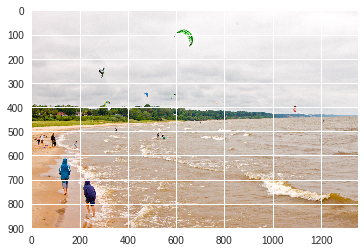

In [0]:
from PIL import Image
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
    plt.imshow(image_np)
    print(image.size, image_np.shape)

In [0]:
#Load a frozen TF model 
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

(636, 1024, 3)
(900, 1352, 3)


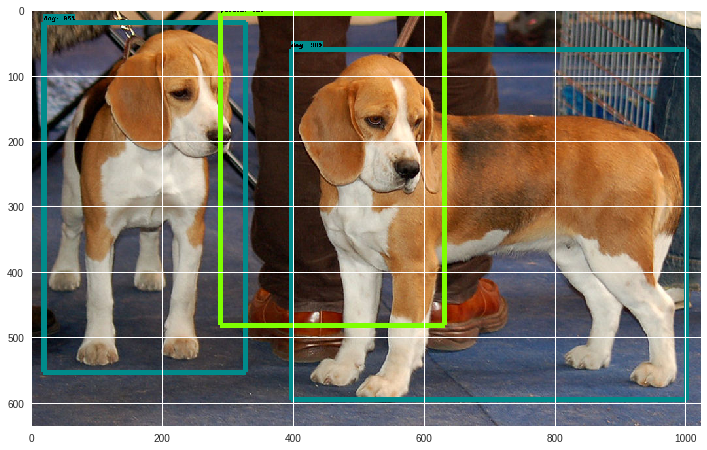

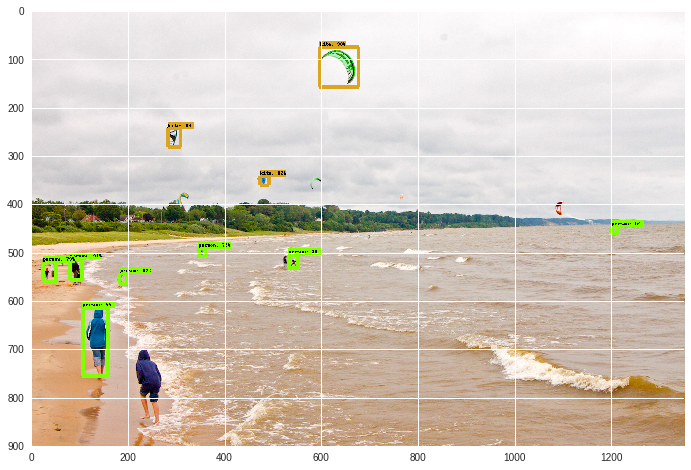

In [0]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            image_process = detect_objects(image_np, sess, detection_graph)
            print(image_process.shape)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_process)

In [0]:
# this portion is to take the video in from dropbox

In [0]:
!curl -o /content/object_detection_assignment/video1.mp4 https://www.dropbox.com/s/w64df94wrpjuruk/video1.mp4?dl=1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0


In [0]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [0]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # you should return the final output (image with lines are drawn on lanes)
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            image_process = detect_objects(image, sess, detection_graph)
            return image_process

In [0]:
white_output = '/content/object_detection_assignment/video1_out.mp4'
clip1 = VideoFileClip("/content/object_detection_assignment/video1.mp4").subclip(0,12)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!s
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video /content/gdrive/My Drive/Video/video1_out.mp4
[MoviePy] Writing video /content/gdrive/My Drive/Video/video1_out.mp4


100%|█████████▉| 360/361 [32:02<00:05,  5.31s/it]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/Video/video1_out.mp4 

CPU times: user 31min 40s, sys: 51.8 s, total: 32min 32s
Wall time: 32min 3s


The Original and Processed Video can be found at the following youtube link.

[Original Video](https://youtu.be/46lo784Ec_U)

[SSD Mobilenet](https://youtu.be/umcir_rUZ7k)

[SSD Inception V2](https://youtu.be/Q3Fx91OanTY)